## Business Understanding
### Research Objective

The goal of this analysis is to examine developmental screening among children ages 0–3 using the 2022 National Survey of Children’s Health (NSCH). Specifically, this project seeks to:

- Estimate the overall rate at which young children receive a developmental screening questionnaire.
- Identify socioeconomic and demographic disparities in screening.
- Develop a baseline predictive model to estimate the probability that a child received a screening.

Developmental screening is a critical early step in identifying developmental delays and connecting children to early intervention services. Missed screenings may delay diagnosis, reduce intervention effectiveness, and increase long-term educational and healthcare costs.

Understanding which children are least likely to receive screening enables policymakers and healthcare providers to design targeted outreach and improve equitable access.


In [42]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

os.makedirs("images", exist_ok=True)


## Data Understanding
### Data Source

This analysis uses the 2022 National Survey of Children’s Health (NSCH) public use file. The NSCH is a nationally representative survey conducted by the U.S. Census Bureau that includes detailed information on child health, healthcare access, and family characteristics.

The dataset includes demographic variables, socioeconomic indicators (including Federal Poverty Level), race and ethnicity, healthcare access measures, and developmental screening questions.

#### Target Variable

The outcome variable is derived from survey item:
k6q12 — "Questionnaire – Development Concerns"
This item indicates whether the caregiver reported that the child received a developmental screening questionnaire.

Target definition:

- 1 = Yes (screening completed)
- 0 = No
- Missing values were excluded

The analysis is restricted to children ages 0–3, the age range in which developmental screening is most relevant.

In [19]:
#Data Loading

DTA_PATH = "data_raw/nsch_2022_topical_stata_extracted/nsch_2022e_topical.dta"
DO_PATH  = "data_raw/nsch_2022_topical_stata_extracted/nsch_2022_topical.do"

df = pd.read_stata(DTA_PATH, convert_categoricals=False)
df.shape


(54103, 484)

## Data Preparation
### Cleaning and Feature Engineering

The following steps were performed:

Created binary target variable DEV_SCREEN from k6q12.

- Filtered dataset to children ages 0–3.
- Removed observations with missing screening status.
- Constructed fpl_pct by averaging six imputed Federal Poverty Level (FPL) variables.

Binned FPL percentage into interpretable categories:

- 0–99%
- 100–199%
- 200–299%
- 300–399%
- 400%+

Combined race and Hispanic ethnicity into a single Race/Ethnicity variable.
Labeled categorical variables using official NSCH codebook definitions.
These steps ensure variables are interpretable and appropriate for modeling.

Federal Poverty Level (FPL) percentage was calculated by averaging six imputed FPL variables provided in the NSCH dataset.


In [43]:
#k6q12 = 1 → Yes (screening questionnaire done) → DEV_SCREEN = 1
#k6q12 = 2 → No → DEV_SCREEN = 0
#k6q12 = NaN → not asked / missing / not in universe (often because it doesn’t apply to that respondent/age)
##
# k6q12: 1=Yes, 2=No, NaN otherwise
df["DEV_SCREEN"] = np.where(df["k6q12"] == 1, 1,
                     np.where(df["k6q12"] == 2, 0, np.nan))

df["DEV_SCREEN"].value_counts(dropna=False)


DEV_SCREEN
NaN    35968
0.0    10753
1.0     7382
Name: count, dtype: int64

## Exploratory Data Analysis (EDA)
### Overall Screening Rate

Among children ages 0–3 in the 2022 NSCH:
- Approximately 45–46% received a developmental screening
- Approximately 54–55% did not

This indicates that developmental screening is not universal and suggests substantial room for improvement.

#### Screening by Federal Poverty Level (FPL)

A clear income gradient is observed:
- Children in the lowest income group (0–99% FPL) have the lowest screening rates.
- Screening rates increase steadily as household income increases.
- Children at 400%+ FPL have the highest screening rates.

This pattern suggests that socioeconomic disadvantage is strongly associated with missed developmental screening.

#### Screening by Race/Ethnicity

Developmental screening rates differ across race/ethnicity groups:
- Non-Hispanic White children have the highest screening rate.
- Hispanic children have lower screening rates.
- Several non-Hispanic minority groups show lower screening rates than White children.
Observed differences range approximately 6–12 percentage points among larger groups.
These disparities may reflect differences in healthcare access, continuity of care, provider practices, or systemic barriers.

#### Screening by Usual Preventive Care

Children with a usual place for preventive care have significantly higher screening rates than those without one.
This finding highlights the importance of:
- Continuity of care
- Access to routine well-child visits
- Healthcare system engagement
Access to preventive care appears to be a strong structural driver of screening.

In [25]:
#Filter Ages 0–3

df_0_3 = df[df["sc_age_years"].between(0, 3)].copy()
df_0_3 = df_0_3[df_0_3["DEV_SCREEN"].notna()].copy()

df_0_3.shape, df_0_3["DEV_SCREEN"].mean()


((10871, 485), 0.4554318829914451)

In [26]:
# Parse Label Maps (Race + Hispanic + Preventive Care)

do_text = Path(DO_PATH).read_text(errors="ignore")

def parse_label_define(label_name: str):
    mapping = {}
    pattern = re.compile(rf'(?im)^\s*label\s+define\s+{re.escape(label_name)}\s+(.*)$')
    for m in pattern.finditer(do_text):
        rest = m.group(1)
        pairs = re.findall(r'(-?\d+)\s+"([^"]*)"', rest)
        for code_str, lab in pairs:
            mapping[int(code_str)] = lab
    return mapping

race_map   = parse_label_define("sc_race_r_lab")
hisp_map   = parse_label_define("sc_hispanic_r_lab")
usualgo_map = parse_label_define("usualgo_lab")


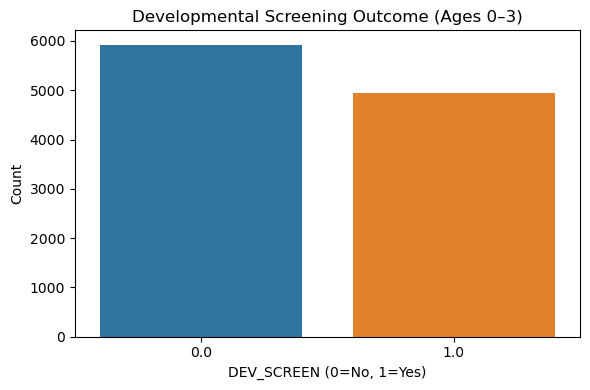

In [36]:
#Target Distribution Plot 

plt.figure(figsize=(6,4))
sns.countplot(x="DEV_SCREEN", data=df_0_3)
plt.title("Developmental Screening Outcome (Ages 0–3)")
plt.xlabel("DEV_SCREEN (0=No, 1=Yes)")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("images/dev_screen_distribution_0_3.png", dpi=300)
plt.show()


In [29]:
#Federal Poverty levels grouping (FPL)

fpl_cols = ["fpl_i1","fpl_i2","fpl_i3","fpl_i4","fpl_i5","fpl_i6"]
tmp = df_0_3.copy()

for c in fpl_cols:
    tmp[c] = pd.to_numeric(tmp[c], errors="coerce")

tmp["fpl_pct"] = tmp[fpl_cols].mean(axis=1)

bins = [-np.inf, 100, 200, 300, 400, np.inf]
labels = ["0–99% FPL", "100–199% FPL", "200–299% FPL", "300–399% FPL", "400%+ FPL"]
tmp["fpl_group"] = pd.cut(tmp["fpl_pct"], bins=bins, labels=labels, right=False)

fpl_summary = (tmp.dropna(subset=["fpl_group"])
               .groupby("fpl_group")["DEV_SCREEN"]
               .agg(n="size", screening_rate="mean")
               .reindex(labels)
               .reset_index())

fpl_summary


,fpl_group,n,screening_rate
0,0–99% FPL,993,0.328298
1,100–199% FPL,1652,0.382567
2,200–299% FPL,2040,0.413725
3,300–399% FPL,1791,0.480179
4,400%+ FPL,4395,0.520819


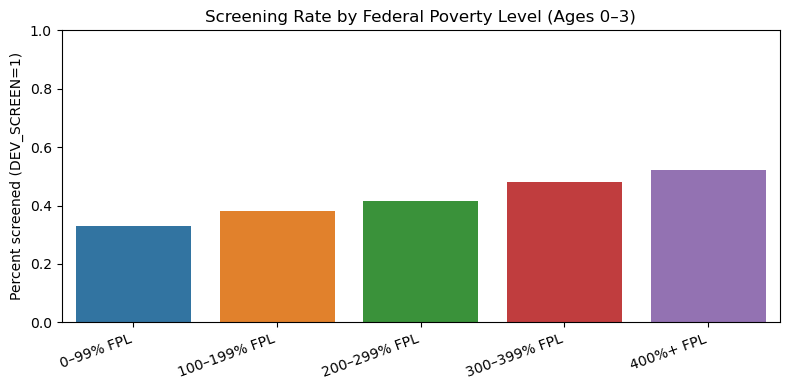

In [37]:
#FPL Plot

rates = fpl_summary.dropna()

plt.figure(figsize=(8,4))
sns.barplot(data=rates, x="fpl_group", y="screening_rate")
plt.title("Screening Rate by Federal Poverty Level (Ages 0–3)")
plt.xlabel("")
plt.ylabel("Percent screened (DEV_SCREEN=1)")
plt.ylim(0, 1)
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.savefig("images/screen_rate_by_fpl.png", dpi=300)
plt.show()


In [44]:
#Race/Ethnicity Combined Summary

tmp = df_0_3.copy()
tmp["race_label"] = tmp["sc_race_r"].map(race_map)
tmp["hisp_code"]  = tmp["sc_hispanic_r"]

def race_eth_group(row):
    hisp = row["hisp_code"]
    race = row["race_label"]
    if pd.isna(hisp) or pd.isna(race):
        return pd.NA
    if hisp == 1:
        return "Hispanic (any race)"
    if hisp == 2:
        return f"Non-Hispanic {race}"
    return pd.NA

tmp["race_eth"] = tmp.apply(race_eth_group, axis=1)

race_summary = (tmp.dropna(subset=["race_eth"])
                .groupby("race_eth")["DEV_SCREEN"]
                .agg(n="size", screening_rate="mean")
                .sort_values("screening_rate", ascending=False)
                .reset_index())

race_summary


,race_eth,n,screening_rate
0,Non-Hispanic White alone,7100,0.482535
1,Non-Hispanic Two or More Races,891,0.443322
2,Hispanic (any race),1649,0.417829
3,Non-Hispanic Asian alone,617,0.364668
4,Non-Hispanic Black or African American alone,546,0.362637
5,Non-Hispanic Native Hawaiian and Other Pacific...,22,0.318182
6,Non-Hispanic American Indian or Alaska Native ...,46,0.239130


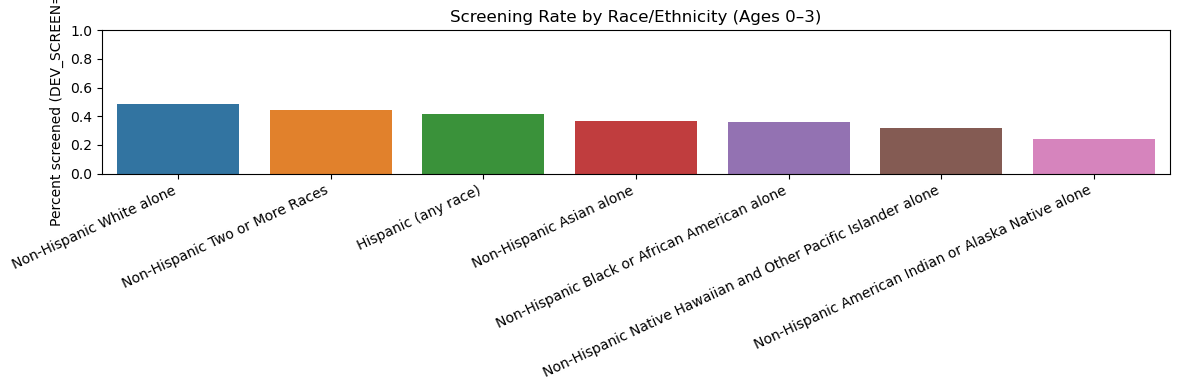

In [38]:
#Race/Ethnicity Combined Summary Plot Ages 0-3
plt.figure(figsize=(12,4))
sns.barplot(data=race_summary, x="race_eth", y="screening_rate")
plt.title("Screening Rate by Race/Ethnicity (Ages 0–3)")
plt.xlabel("")
plt.ylabel("Percent screened (DEV_SCREEN=1)")
plt.ylim(0, 1)
plt.xticks(rotation=25, ha="right")
plt.tight_layout()
plt.savefig("images/screen_rate_by_race_ethnicity.png", dpi=300)
plt.show()


In [32]:
#Preventive Care Summary 

tmp = df_0_3.copy()
tmp["usualgo_label"] = tmp["usualgo"].map(usualgo_map)

preventive_care = (tmp.dropna(subset=["usualgo_label"])
                 .groupby("usualgo_label")["DEV_SCREEN"]
                 .agg(n="size", screening_rate="mean")
                 .reindex(["Yes","No"])
                 .reset_index())

preventive_care


,usualgo_label,n,screening_rate
0,Yes,10255,0.474793
1,No,526,0.142586


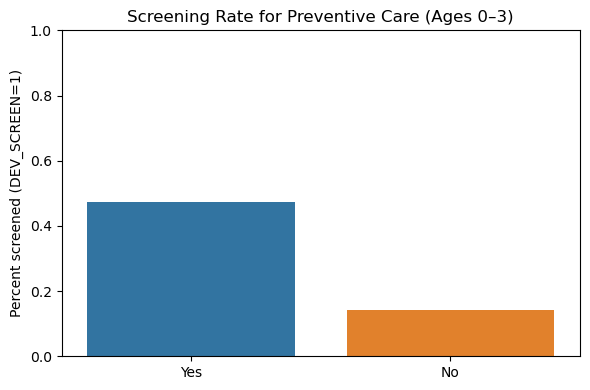

In [41]:
#Preventive Care Summary Plot

plt.figure(figsize=(6,4))
sns.barplot(data=preventive_care, x="usualgo_label", y="screening_rate")
plt.title("Screening Rate for Preventive Care (Ages 0–3)")
plt.xlabel("")
plt.ylabel("Percent screened (DEV_SCREEN=1)")
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig("images/screen_rate_by_usual_preventive_care.png", dpi=300)
plt.show()


## Baseline Predictive Model
### Model Selection

A Logistic Regression model was used as a baseline classifier due to:
- Interpretability
- Appropriateness for binary outcomes
- Ability to estimate screening probability

Features included:
- Federal Poverty Level (continuous)
- Race
- Hispanic ethnicity
- Usual preventive care

#### Evaluation Metric

ROC-AUC was selected as the primary evaluation metric because:
- It measures discrimination ability independent of threshold
- It is appropriate for binary classification
- It is robust to moderate class imbalance

The baseline model provides a reference point for future improvement using more complex models (e.g., Random Forest, Gradient Boosting).

In [35]:
#Baseline Model (Logistic Regression)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

# Minimal feature set (expand later)
feature_cols = ["fpl_pct", "sc_race_r", "sc_hispanic_r", "usualgo"]
model_df = df_0_3.copy()

# Build fpl_pct again for modeling
for c in fpl_cols:
    model_df[c] = pd.to_numeric(model_df[c], errors="coerce")
model_df["fpl_pct"] = model_df[fpl_cols].mean(axis=1)

X = model_df[feature_cols]
y = model_df["DEV_SCREEN"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

cat_features = ["sc_race_r", "sc_hispanic_r", "usualgo"]
num_features = ["fpl_pct"]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
        ("num", "passthrough", num_features),
    ]
)

clf = Pipeline(steps=[
    ("prep", preprocess),
    ("model", LogisticRegression(max_iter=2000))
])

clf.fit(X_train, y_train)

proba = clf.predict_proba(X_test)[:, 1]
pred  = (proba >= 0.5).astype(int)

print("ROC-AUC:", roc_auc_score(y_test, proba))
print(classification_report(y_test, pred))


ROC-AUC: 0.6129759201851286
              precision    recall  f1-score   support

           0       0.62      0.63      0.63      1480
           1       0.55      0.53      0.54      1238

    accuracy                           0.59      2718
   macro avg       0.58      0.58      0.58      2718
weighted avg       0.58      0.59      0.59      2718



## Key Findings & Next Steps
#### Key Findings

- Developmental screening occurs in fewer than half of children ages 0–3.
- A strong socioeconomic gradient exists: lower-income children are less likely to be screened.
- Racial and ethnic disparities are present.
- Having a usual source of preventive care is strongly associated with higher screening rates.
- Baseline predictive modeling demonstrates that screening status can be partially predicted using socioeconomic and access-related features.

#### Next Steps

- Expand modeling with additional predictors (insurance, parental education, region).
- Incorporate survey weights into modeling for population-level inference.
- Evaluate tree-based ensemble models for improved predictive performance.
- Quantify disparity magnitude using adjusted models (e.g., odds ratios).
- Translate findings into policy-relevant recommendations for early childhood intervention programs.

## Model Interpretation

The Logistic Regression baseline model achieved an ROC-AUC of approximately 0.6129759201851286.

ROC-AUC measures the model’s ability to distinguish between children who received a screening and those who did not. 
A value of 0.50 indicates random guessing, while 1.00 indicates perfect discrimination.

The baseline model demonstrates moderate predictive ability, indicating that socioeconomic status, race/ethnicity, and access to preventive care contain meaningful signal in predicting developmental screening status.

This baseline will serve as a comparison point for more advanced models in Module 24.


## Limitations

The NSCH dataset is cross-sectional and based on caregiver self-report, which may introduce recall bias. 
Additionally, subgroup estimates for smaller populations should be interpreted cautiously due to limited sample size.
